# New York City Airbnb
Dataset source - [kaggle](kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

В ходе выполнения задания опробовано следующее:
- scaling фичей разными способами (MinMax, StandardScaler, Robust). Какой метод использовать значительно не влияет на результаты.
- трансформации целевой переменной (логарифм, корень квадратный), улучшает качество модели
- разные формы кодирования категориальный фич - если кодировать все как dummy уходит дольше времени на работу алгоритмов. Все категории в явном виде влияют на величину целевой переменной, можно их считать ordinal категориальными данными и кодировать с учетом этого.
- исключение выбросов целевой переменной значительно улучшает качество модели
- формирование нового сета фичей с помощью PolynomialFeatures для отлова нелинейных зависимостей. Значительно лучше работает с нетрансформированной целевой переменной, лучше метрики RMSE, R2
- разные алгоритмы линейной регрессии (Ridge, Lasso, ElasticNet) - не влияет в значительной мере

## Import modules

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import (StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler, 
                                   PolynomialFeatures)
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score)
from sklearn.linear_model import (LassoCV,
                                  RidgeCV,
                                  ElasticNetCV)
from sklearn.metrics import (mean_absolute_error, 
                             mean_squared_error, 
                             r2_score)

## Read data

In [2]:
df = pd.read_csv('data/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


## EDA

In [3]:
to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review']
df.drop(to_drop, axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [5]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Missing data
Посмотрим сколько данных отсутствует

In [6]:
df.isna().sum()/df.shape[0]

neighbourhood_group               0.000000
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
reviews_per_month                 0.205583
calculated_host_listings_count    0.000000
availability_365                  0.000000
dtype: float64

Пропуски в данных есть в столбце reviews_per_month, отсутствует 1/5 данных, убрать строки с пропусками не вариант.
Возможно эти данные отсутсвуют для записей с 0 number_of_reviews?

In [7]:
df[df.reviews_per_month.isna()].number_of_reviews.describe()

count    10052.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: number_of_reviews, dtype: float64

### Target distribution
Посмотрим распределение цены

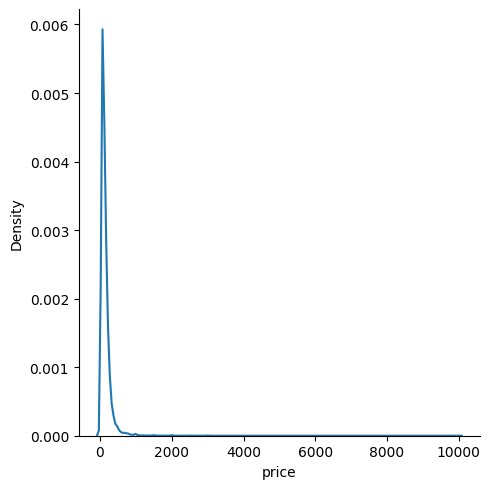

In [8]:
sns.displot(data=df, x='price', kind='kde')
plt.show()

99% цен ниже 800 долларов. Возможно стоит удалить выбросы?

In [9]:
np.quantile(df.price, 0.99)

799.0

Возможно целевую переменную стоит логарифмировать или проборазовать другим способом, уменьшить перекос? 

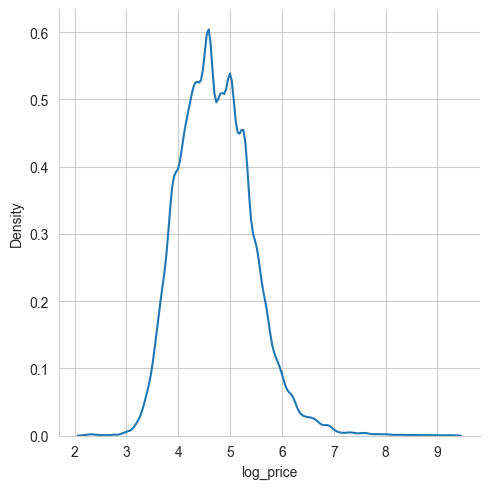

In [277]:
df['log_price'] = np.log(df.price.replace({0: 0}))
sns.displot(data=df, x='log_price', kind='kde')
plt.show()

In [11]:
df.room_type.value_counts(normalize=True)

Entire home/apt    0.519665
Private room       0.456611
Shared room        0.023724
Name: room_type, dtype: float64

In [12]:
df.neighbourhood_group.value_counts(normalize=True)

Manhattan        0.443011
Brooklyn         0.411167
Queens           0.115881
Bronx            0.022313
Staten Island    0.007629
Name: neighbourhood_group, dtype: float64

### Target distribution by other variables
Посмотрим на категориальные признаки и распределения цены между разными признаками.

In [13]:
cat_cols = ['room_type', 'neighbourhood_group', 'neighbourhood']
for col in cat_cols:
    cat_unique = df[col].unique()
    print(f'{col} ({len(cat_unique)})\n', df[col].unique())

room_type (3)
 ['Private room' 'Entire home/apt' 'Shared room']
neighbourhood_group (5)
 ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
neighbourhood (221)
 ['Kensington' 'Midtown' 'Harlem' 'Clinton Hill' 'East Harlem'
 'Murray Hill' 'Bedford-Stuyvesant' "Hell's Kitchen" 'Upper West Side'
 'Chinatown' 'South Slope' 'West Village' 'Williamsburg' 'Fort Greene'
 'Chelsea' 'Crown Heights' 'Park Slope' 'Windsor Terrace' 'Inwood'
 'East Village' 'Greenpoint' 'Bushwick' 'Flatbush' 'Lower East Side'
 'Prospect-Lefferts Gardens' 'Long Island City' 'Kips Bay' 'SoHo'
 'Upper East Side' 'Prospect Heights' 'Washington Heights' 'Woodside'
 'Brooklyn Heights' 'Carroll Gardens' 'Gowanus' 'Flatlands' 'Cobble Hill'
 'Flushing' 'Boerum Hill' 'Sunnyside' 'DUMBO' 'St. George' 'Highbridge'
 'Financial District' 'Ridgewood' 'Morningside Heights' 'Jamaica'
 'Middle Village' 'NoHo' 'Ditmars Steinway' 'Flatiron District'
 'Roosevelt Island' 'Greenwich Village' 'Little Italy' 'East Flatbush'
 'Tompkin

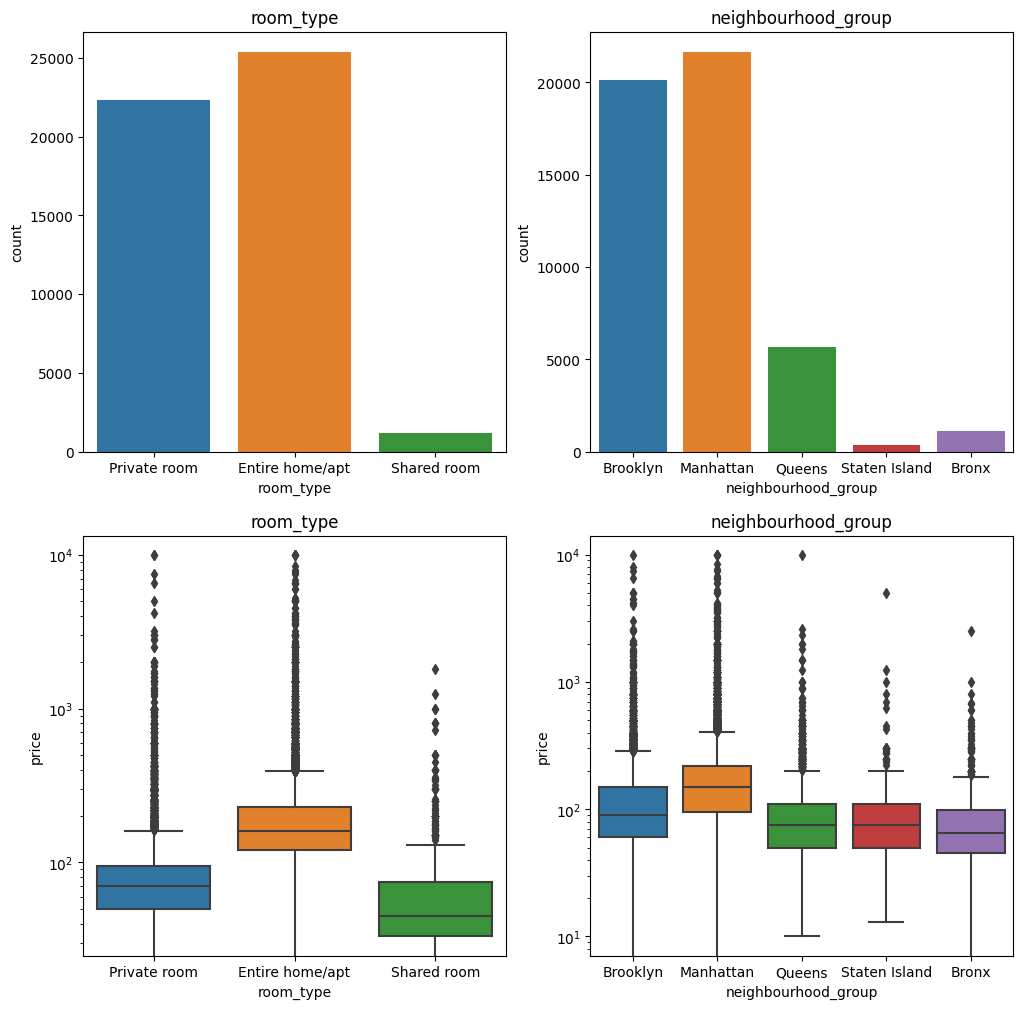

In [14]:
cats = ('room_type', 'neighbourhood_group')
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(12, 12)
for i, cat in enumerate(cats):
    # countplot
    ax[0,i].set_title(cat)
    sns.countplot(data=df, x=cat, ax=ax[0,i])
    # boxplot
    ax[1,i].set_title(cat)
    sns.boxplot(data=df, x=cat, y='price', ax=ax[1,i])
    ax[1,i].set_yscale('log')
plt.show()

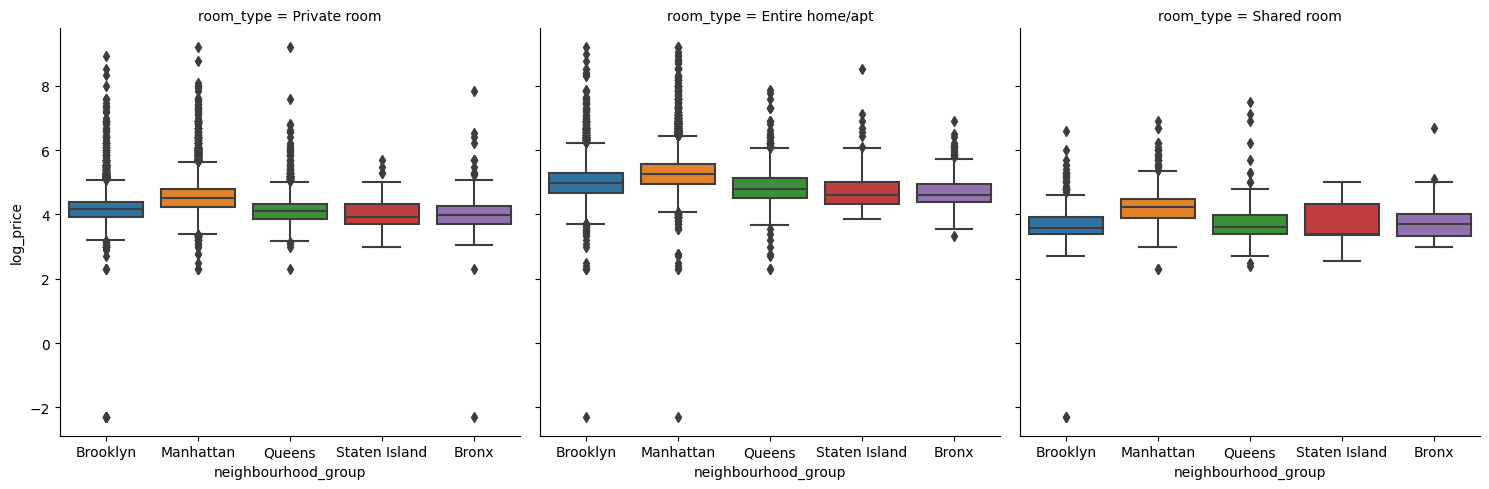

In [15]:
sns.catplot(kind='box', data=df, x='neighbourhood_group', y='log_price', col='room_type')
plt.show()

### Scatter plots

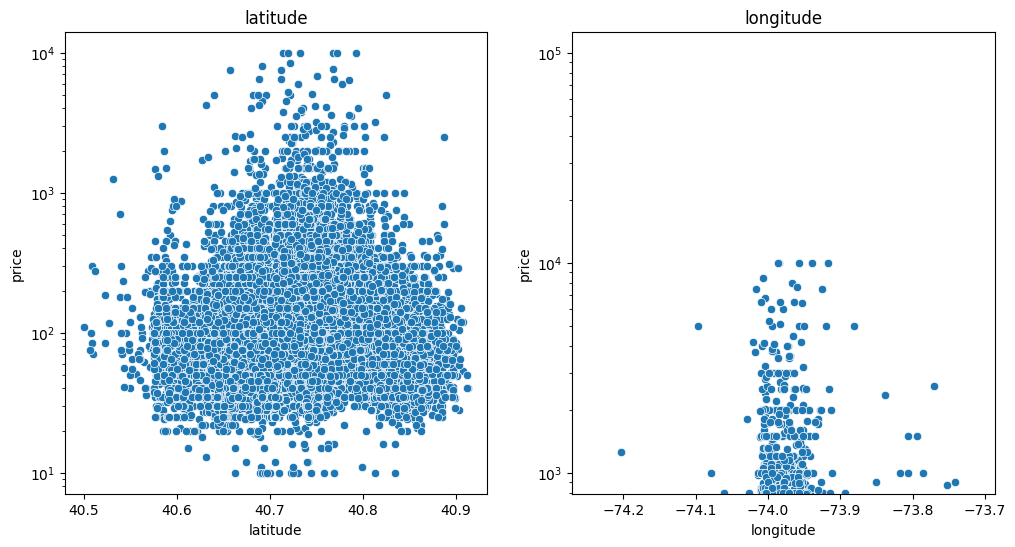

In [16]:
cols = ('latitude', 'longitude')
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12, 6)
for i, col in enumerate(cols):
    ax[i].set_title(col)
    sns.scatterplot(data=df, x=col, y='price', ax=ax[i])
    ax[i].set_yscale('log')
plt.show()

Может быть расстояние до самого дорогого района (Манхеттена) будет лучше для предсказания цены?

In [17]:
mh_coord = np.array([40.7831, -73.9712])
df['dist_to_mh'] = np.sqrt((df.latitude-mh_coord[0])**2 + (df.longitude-mh_coord[1])**2)

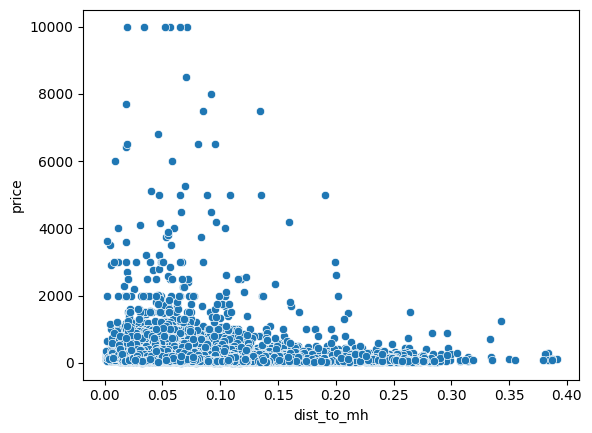

In [18]:
sns.scatterplot(data=df, x='dist_to_mh', y='price')
plt.show()

In [19]:
df.columns.tolist()

['neighbourhood_group',
 'neighbourhood',
 'latitude',
 'longitude',
 'room_type',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365',
 'log_price',
 'dist_to_mh']

In [20]:
col_order = ['price',
             'log_price',
             'room_type',
             'latitude',
             'longitude',
             'dist_to_mh',
             'neighbourhood_group',
             'neighbourhood',             
             'minimum_nights',
             'number_of_reviews',
             'reviews_per_month', 
             'calculated_host_listings_count',
             'availability_365']
df = df[col_order]

### Correlation

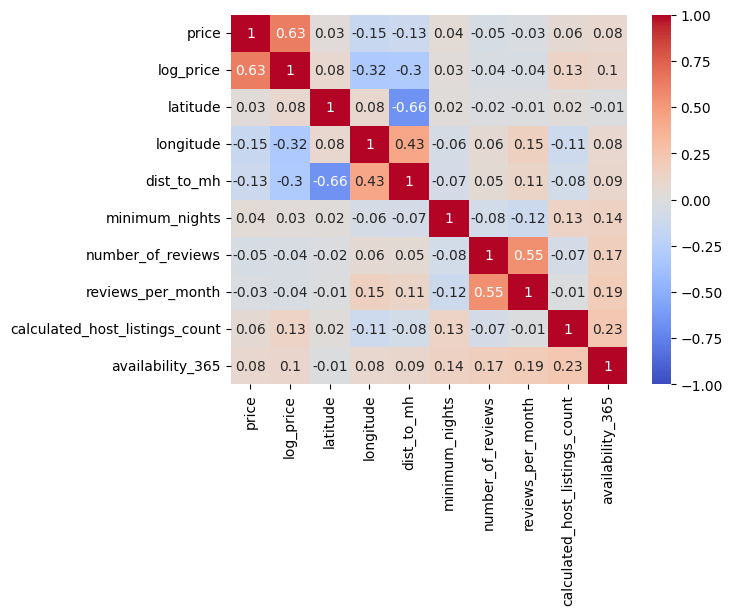

In [21]:
cor_tab = df.corr().apply(np.round, decimals=2)
# Palette
pal = sns.color_palette("coolwarm", 10000)
sns.heatmap(data=cor_tab, annot=True, cmap=pal, vmin=-1, center=0, vmax=1)
plt.show()

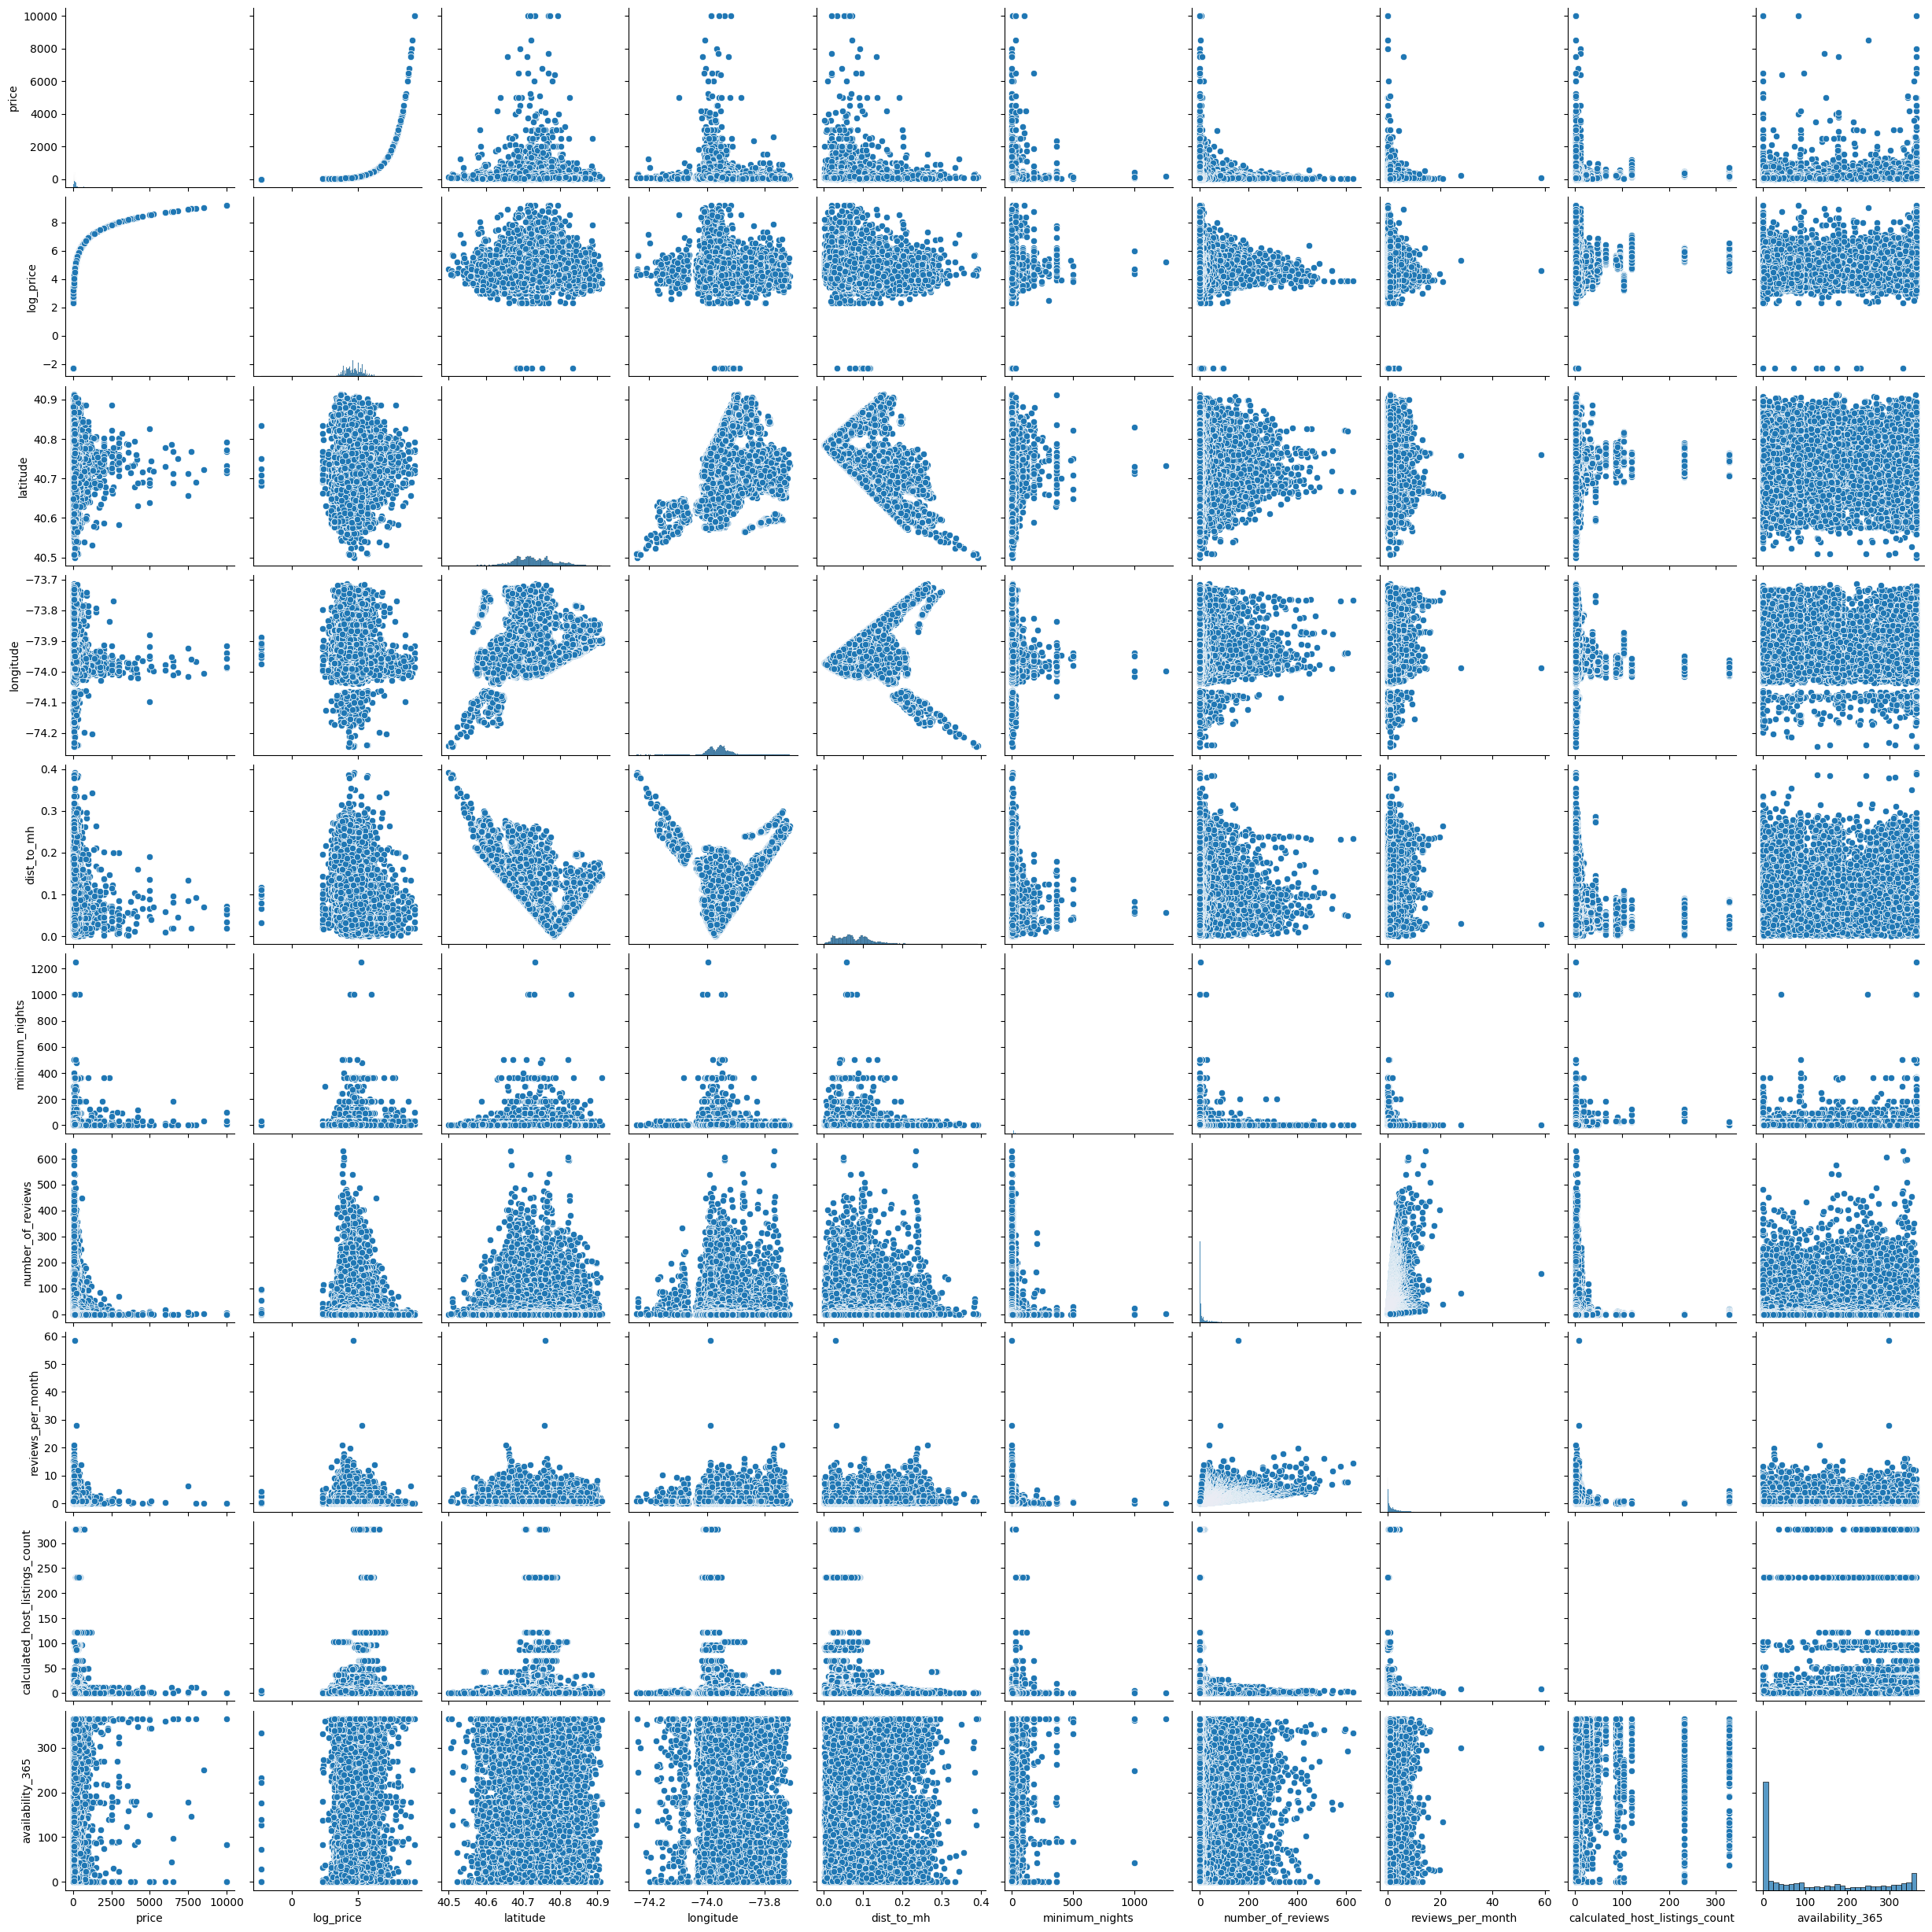

In [22]:
sns.pairplot(df)
plt.show()

In [23]:
# Returns dictionary object from two lists
def create_dict(keys, values):
    return dict(zip(keys, values))

## Pre-processing
### Missing data
Мы ранее выяснили, что данные reviews_per_month отсутствуют для записей с 0 number_of_reviews. Заменим отсутсвующие данные на специальное значение -1

In [24]:
df.reviews_per_month.fillna(-1, inplace=True)
df.reviews_per_month.isna().sum()

0

### Categorical variables
- neighbourhood_group - dummy
- neighbourhood - ordinal by median
- room_type - ordinal by median

In [201]:
pr_df = df.copy(deep=True)
# neighbourhood_group, neighbourhood
#pr_df.drop('neighbourhood', axis=1, inplace=True)
#pr_df.drop(['latitude', 'longitude'], axis=1, inplace=True)
#pr_df.drop('dist_to_mh', axis=1, inplace=True)

pr_df = pd.get_dummies(pr_df, columns=['neighbourhood_group'])
#pr_df = pd.get_dummies(pr_df, columns=['neighbourhood_group', 'neighbourhood'])
#pr_df.columns.tolist()

# neighbourhood
nh_list = pr_df.groupby('neighbourhood')['price'].agg(np.median).sort_values().index.tolist()
nh_mapping = create_dict(nh_list, list(range(len(nh_list))))
pr_df['neighbourhood'] = pr_df.neighbourhood.map(nh_mapping)
# room_type
rt_ord = {'Shared room': 1, 
          'Private room': 2, 
          'Entire home/apt': 3}
pr_df['room_type'] = pr_df.room_type.map(rt_ord)
pr_df.head()

,price,log_price,room_type,latitude,longitude,dist_to_mh,neighbourhood,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island
0,149,5.003946,2,40.64749,-73.97237,0.135615,72,1,9,0.21,6,365,0,1,0,0,0
1,225,5.416100,3,40.75362,-73.98377,0.032048,213,1,45,0.38,2,355,0,0,1,0,0
2,150,5.010635,2,40.80902,-73.94190,0.039120,134,3,0,-1.00,1,365,0,0,1,0,0
3,89,4.488636,3,40.68514,-73.95976,0.098626,165,1,270,4.64,1,194,0,1,0,0,0
4,80,4.382027,3,40.79851,-73.94399,0.031271,145,10,9,0.10,1,0,0,0,1,0,0


### Outliers
99% данных целевой переменной попадают в интервал между 0 и 800. Мы можем позволить себе дропнуть 1% выбросов

In [202]:
print(np.quantile(pr_df.price, 0.99))
pr_df = pr_df[pr_df.price <= 800]

799.0


### Feature engineering
Какие преобразования фичей и целовой переменной можно испробовать

Feature scaling:
1. Normalization (MinMaxScaler)
2. Standardization (StandardScaler)
3. Robust to outliers (RobustScaler)

Target variable transformations:
1. Raw (без преобразований)
2. Log
3. Sqrt

Дополнительно:
- PolynomialFeatures чтобы поймать нелинейные зависимости

### Train Test Validation split

In [284]:
# divide to train and test
X_train, X_test, y_train, y_test = train_test_split(pr_df.drop(['price', 'log_price'], axis=1),
                                                    pr_df['price'],
                                                    test_size=0.3, 
                                                    random_state=77)

# divide to train2 and validation
X_train2, X_val, y_train2, y_val = train_test_split(X_train, y_train, 
                                                    test_size=0.3, 
                                                    random_state=77)

## Modeling
### Этап 1
#### Подготовка

In [146]:
# Features
# Normalization
n_scaler = MinMaxScaler()
nX_train = n_scaler.fit_transform(X_train2)
nX_test = n_scaler.transform(X_val)
# Standartization
s_scaler = StandardScaler()
sX_train = s_scaler.fit_transform(X_train2)
sX_test = s_scaler.transform(X_val)
# Robust to outliers
r_scaler = RobustScaler()
rX_train = r_scaler.fit_transform(X_train2)
rX_test = r_scaler.transform(X_val)

# Target
# Log target
log_y_train = np.log(y_train2.replace({0: 1}))
# Sqrt target
sqrt_y_train = np.sqrt(y_train2)

In [147]:
# Scaling labels
scl_lab = ['normalized', 'standardized', 'robust']
# Create dictionaries of features to try
Xtrain = create_dict(scl_lab, [nX_train, sX_train, rX_train])
Xtest = create_dict(scl_lab, [nX_test, sX_test, rX_test])
# Target trasformation labels
transf_lab = ['raw', 'log', 'sqrt']
# Create dictionaries of targets
Ytrain = create_dict(transf_lab, [y_train2, log_y_train, sqrt_y_train])
Ytest = create_dict(transf_lab, [y_val, log_y_test, sqrt_y_test])
# Target back transformations
t_trans = create_dict(transf_lab, [lambda x: x, np.exp, lambda x: x**2])

#### Обучение

In [119]:
# Linear regressions to train
lr_models = [RidgeCV(), LassoCV(),ElasticNetCV()]
# DataFrame to save results
res_cols = ['model', 'features', 'target']

In [264]:
from sklearn.base import clone
def train_rate(models,
               X_train, y_train, 
               X_test, y_test, 
               func=lambda x: x, 
               random_state=777):
    result = list()    
    for model in models:
        res = dict()
        np.random.seed(random_state)
        mdl = clone(model)
        reg = mdl.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
        res['model'] = reg
        res['MAE'] = mean_absolute_error(y_test, func(y_pred))
        res['RMSE'] = mean_squared_error(y_test, func(y_pred), squared=False)
        res['R2'] = r2_score(y_test, func(y_pred))
        result.append(res)
    return result

In [121]:
results = pd.DataFrame(columns=res_cols)
# Feature loop
for key in Xtrain.keys():
    sc_part = pd.DataFrame(columns=res_cols)
    # Target transformation loop
    for tkey in Ytrain.keys():
        t_part = pd.DataFrame(columns=res_cols)
        # Linear regressions
        lr_part = train_rate(lr_models, 
                             Xtrain[key], Ytrain[tkey], 
                             Xtest[key], y_val, 
                             t_trans[tkey])
        t_part = pd.concat([t_part, pd.DataFrame(lr_part)], axis=0)
        t_part['target'] = tkey
        # Mark target transformation
        sc_part = pd.concat([sc_part, t_part], axis=0)
    sc_part['features'] = key
    #display(sc_part)
    results = pd.concat([results, sc_part])

#### Сравнение

In [122]:
results.sort_values(['RMSE','MAE', 'R2'])

,model,features,target,MAE,RMSE,R2
0,RidgeCV(),standardized,sqrt,49.588317,84.549609,0.364115
0,RidgeCV(),robust,sqrt,49.585606,84.553281,0.364060
1,LassoCV(),standardized,sqrt,49.581798,84.557798,0.363992
2,ElasticNetCV(),standardized,sqrt,49.575459,84.569096,0.363822
0,RidgeCV(),normalized,sqrt,49.601162,84.585644,0.363573
1,LassoCV(),normalized,sqrt,49.595698,84.600696,0.363346
1,LassoCV(),robust,sqrt,49.568404,84.765919,0.360857
2,ElasticNetCV(),normalized,sqrt,49.689932,84.856823,0.359486
0,RidgeCV(),normalized,raw,53.779551,85.097273,0.355850
1,LassoCV(),normalized,raw,53.776748,85.101250,0.355790


In [123]:
sum_ftr = results.groupby('features').mean().sort_values(['RMSE','MAE', 'R2'])
sum_target = results.groupby('target').mean().sort_values(['RMSE','MAE', 'R2'])
summary = results.groupby(['features', 'target']).mean()
display(sum_ftr, sum_target, summary)

,MAE,RMSE,R2
features,,,
standardized,50.406933,85.012504,0.357123
normalized,50.447140,85.179132,0.354594
robust,50.996136,85.863961,0.343852


,MAE,RMSE,R2
target,,,
sqrt,49.594336,84.685016,0.362073
log,47.933407,85.462611,0.350306
raw,54.322465,85.907970,0.343189


MAE       RMSE        R2
features     target                                
normalized   log     47.967778  85.457355  0.350387
             raw     53.744711  85.398985  0.351259
             sqrt    49.628931  84.681054  0.362135
robust       log     47.907334  85.569758  0.348675
             raw     55.508854  87.206966  0.322771
             sqrt    49.572220  84.815160  0.360109
standardized log     47.925110  85.360719  0.351856
             raw     53.713831  85.117959  0.355537
             sqrt    49.581858  84.558834  0.363976

#### Итог
Не видно особой разницы между вариантами скейлинга фичей.
Логарифмическое и корень квадратный преобразования целовой переременной дает лучшие результаты, чем необработанные данные. 
Итого для финального обучения и теста будем использовать следующее: 
1. Стандартизация и корень квадратный таргета
2. Стандартизация и логарифмическое преобразование таргета
3. Полином второй степени стандартизированных фич и все 3 вида фичей

### Этап 2
#### Подготовка

In [279]:
# Features
# Standartization
s_scaler = StandardScaler()
sX_train = s_scaler.fit_transform(X_train)
sX_test = s_scaler.transform(X_test)
# Polynomial
p2 = PolynomialFeatures(degree=2)
p2X_train = p2.fit_transform(sX_train)
p2X_test = p2.transform(sX_test)

# Target
# Log target
log_y_train = np.log(y_train.replace({0: 1}))
# Sqrt target
sqrt_y_train = np.sqrt(y_train)

#### Обучение

In [280]:
ftr_target_labels = ['standardized_sqrt', 'standardized_log', 'polynomial_raw', 'polynomial_sqrt', 'polynomial_log']
ftr_target = zip(ftr_target_labels, 
                 [sX_train, sX_train, p2X_train, p2X_train, p2X_train],
                 [sX_test, sX_test, p2X_test, p2X_test, p2X_test],
                 [sqrt_y_train, log_y_train, y_train, sqrt_y_train, log_y_train],
                 [lambda x: x**2, np.exp, lambda x: x,lambda x: x**2, np.exp ])

lr_models = [RidgeCV(alphas = [0.1, 0.5, 1, 3, 6, 8, 10]), 
             LassoCV(), 
             ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5 , 0.7, 0.9, 0.95, 0.99])]
lr_model_desc = ['Ridge', 'Lasso', 'ElasticNet']
res_cols = ['model', 'features_target', 'MAE', 'RMSE', 'R2']
results = pd.DataFrame(columns=res_cols)
for lab, train_X, test_X, train_y, func in ftr_target:
    sc_part = pd.DataFrame(columns=res_cols)
    lr_dict = train_rate(lr_models, 
                         train_X, train_y, 
                         test_X, y_test, func)
    sc_part = pd.concat([sc_part, pd.DataFrame(lr_dict)])
    sc_part['model_str'] = lr_model_desc
    sc_part['features_target'] = lab
    #display(sc_part)
    results = pd.concat([results, sc_part], axis=0)

#### Сравнение

In [281]:
results

,model,features_target,MAE,RMSE,R2,model_str
0,"RidgeCV(alphas=[0.1, 0.5, 1, 3, 6, 8, 10])",standardized_sqrt,48.942382,83.120984,0.372583,Ridge
1,LassoCV(),standardized_sqrt,48.940403,83.135913,0.372358,Lasso
2,"ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9...",standardized_sqrt,48.940369,83.136019,0.372356,ElasticNet
0,"RidgeCV(alphas=[0.1, 0.5, 1, 3, 6, 8, 10])",standardized_log,47.333945,83.907333,0.360656,Ridge
1,LassoCV(),standardized_log,47.331734,83.934592,0.360241,Lasso
2,"ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9...",standardized_log,47.331513,83.936524,0.360211,ElasticNet
0,"RidgeCV(alphas=[0.1, 0.5, 1, 3, 6, 8, 10])",polynomial_raw,49.334223,81.664323,0.394381,Ridge
1,LassoCV(),polynomial_raw,49.236789,81.520408,0.396514,Lasso
2,"ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9...",polynomial_raw,49.228512,81.513951,0.396609,ElasticNet
0,"RidgeCV(alphas=[0.1, 0.5, 1, 3, 6, 8, 10])",polynomial_sqrt,47.094504,87.852294,0.299125,Ridge


На логарифмируемом таргете полином выдает неадекватные метрики, выбросим не будем рассматривать это в сравнении

In [282]:
results = results[results.features_target != 'polynomial_log']

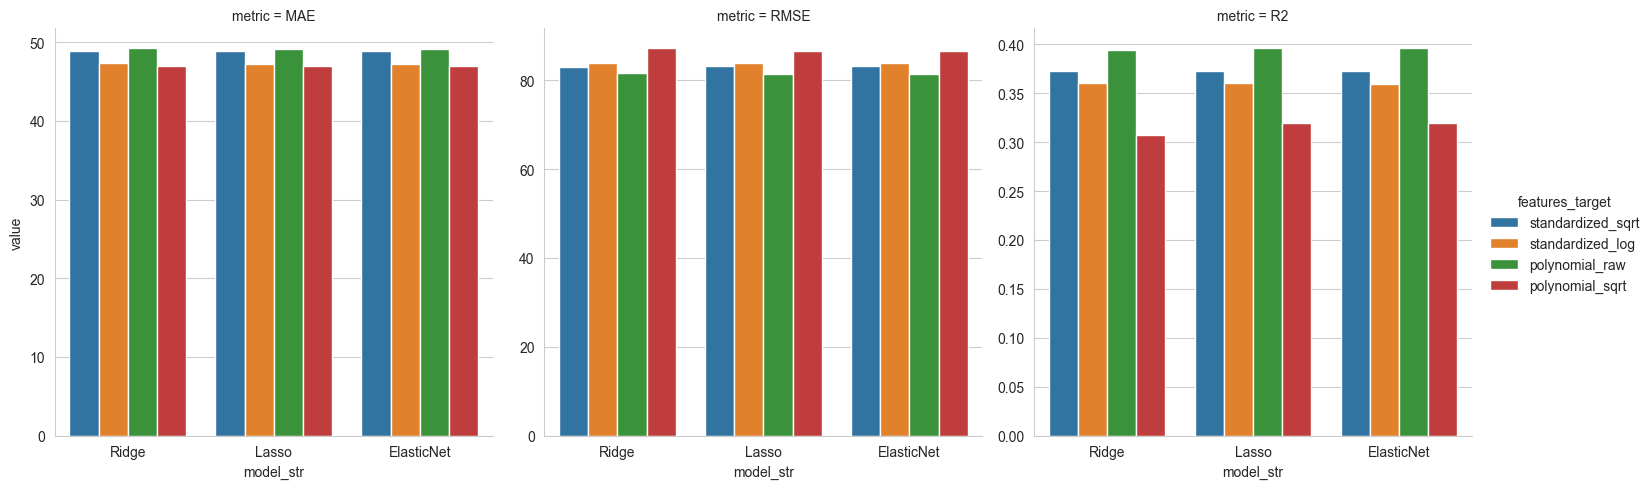

In [ ]:
res_long = results.drop('model', axis=1).melt(id_vars=['features_target', 'model_str'], var_name='metric')

sns.set_style("whitegrid")
sns.catplot(data=res_long, kind='bar', x='model_str', y='value', hue='features_target', col='metric', sharey=False)
plt.show()

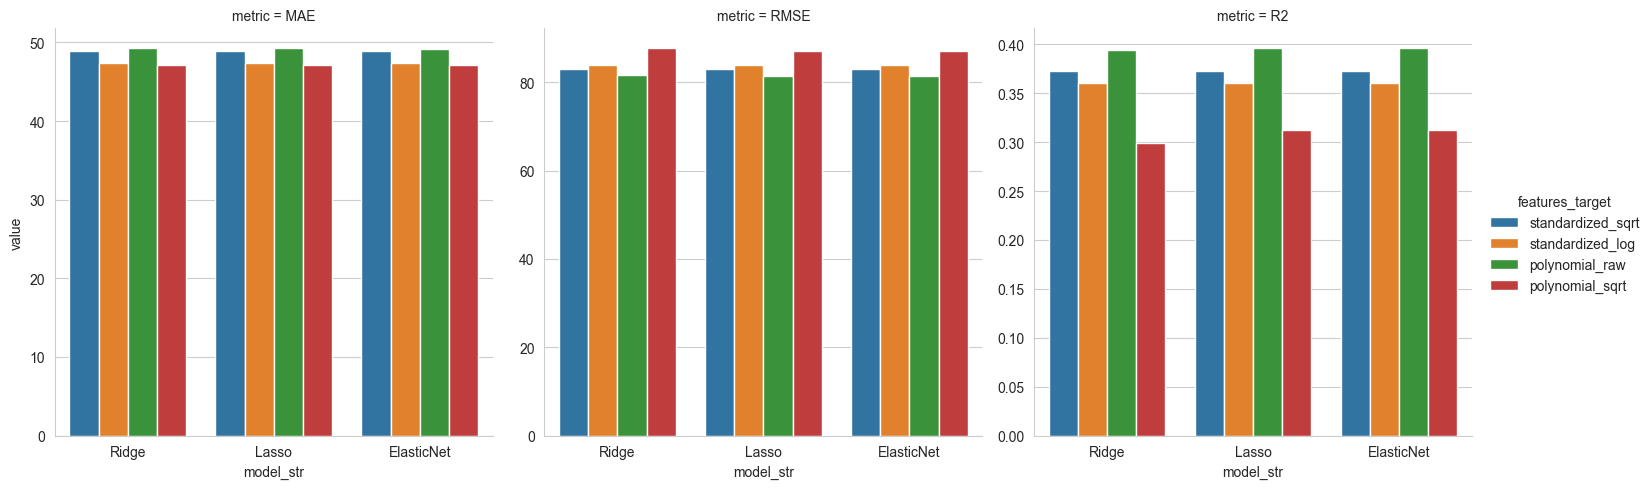

In [283]:
res_long = results.drop('model', axis=1).melt(id_vars=['features_target', 'model_str'], var_name='metric')

sns.set_style("whitegrid")
sns.catplot(data=res_long, kind='bar', x='model_str', y='value', hue='features_target', col='metric', sharey=False)
plt.show()

Выбор алгоритма практически не влияет на качество модели. Наибольшую значимость имеют трансформации и выбросы целевой переменной. Данные скорее всего имеют нелинейную зависимость, поэтому некоторые из метрик(RMSE, R2) лучше, когда генерируем полином из фичей.

#### Feature Importance

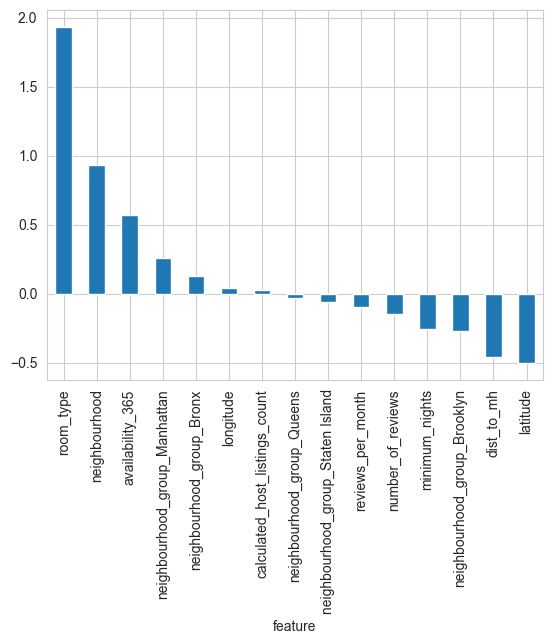

In [270]:
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": results['model'].iloc[0].coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot.bar();
plt.show()

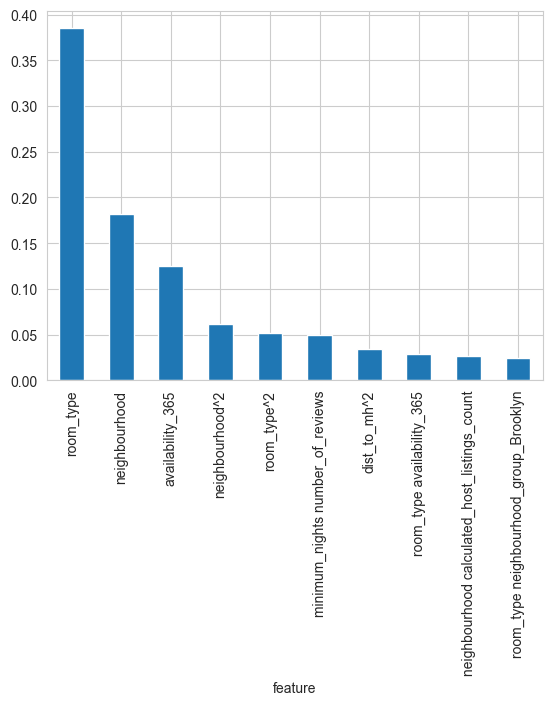

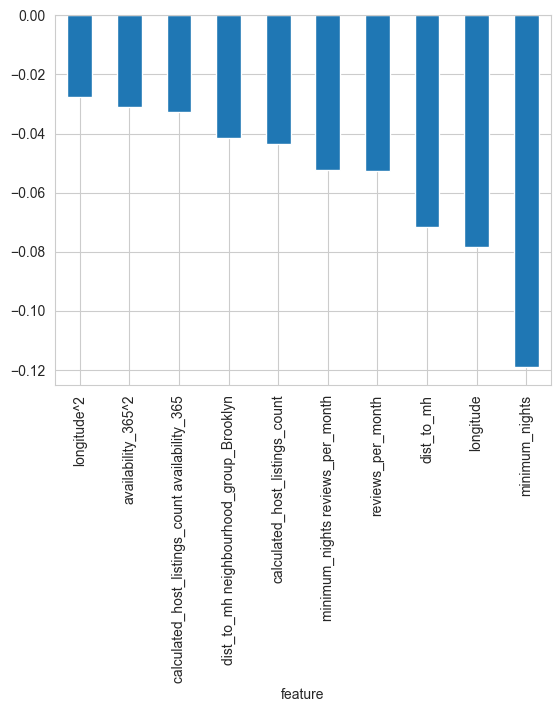

In [276]:
pol_names = p2.get_feature_names_out(X_train.columns)
featureImportance = pd.DataFrame({"feature": pol_names, 
                                  "importance": results['model'].iloc[-1].coef_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].iloc[:10].plot.bar();
plt.show()
featureImportance["importance"].iloc[-10:].plot.bar();
plt.show()